<a href="https://colab.research.google.com/github/farroshsy/Clustering_BigData/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Big Data Assignment for Clustering**
## Building A End to End Clustering with PySpark
---
Name: Farros Hilmi Syafei 
<br>
Student ID: 5025201012
<br>
Class: Big Data A
<br>
Lecturer: Abdul Munif, S.Kom., M.Sc.


## Source:
1. https://runawayhorse001.github.io/LearningApacheSpark/clustering.html
2. Part I: https://medium.com/@josephgeorgelewis2000/end-to-end-pyspark-clustering-part-i-using-colab-for-pyspark-and-collecting-data-6b94b58baeab
3. Part II: https://medium.com/@josephgeorgelewis2000/end-to-end-pyspark-clustering-part-ii-preprocessing-and-model-building-in-colab-1c2d0d8f2a23

## Source 1 - LearningApacheSpark Clustering by runawayhorse001

### Setting Up PySpark Environment

In [53]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark K-means example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### Load the data

In [55]:
df = spark.read.format('csv') \
               .options(header='true', inferschema='true') \
               .load("./Iris.csv", header=True)

### Data exploration


In [56]:
df.show(5,True)
df.printSchema()

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows

root
 |-- Id: integer (nullable = true)
 |-- SepalLengthCm: double (nullable = true)
 |-- SepalWidthCm: double (nullable = true)
 |-- PetalLengthCm: double (nullable = true)
 |-- PetalWidthCm: double (nullable = true)
 |-- Species: string (nullable = true)



In [57]:
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+--------------+
|summary|                Id|     SepalLengthCm|       SepalWidthCm|     PetalLengthCm|      PetalWidthCm|       Species|
+-------+------------------+------------------+-------------------+------------------+------------------+--------------+
|  count|               150|               150|                150|               150|               150|           150|
|   mean|              75.5| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|          null|
| stddev|43.445367992456916|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|          null|
|    min|                 1|               4.3|                2.0|               1.0|               0.1|   Iris-setosa|
|    max|               150|               7.9|                4.4|               6.9|               2.5|Iris-virginica|
+-------+------------------+----

### Convert Data

In [58]:
# convert the data to dense vector
from pyspark.ml.linalg import Vectors

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

You are strongly encouraged to try my get_dummy function for dealing with the categorical data in complex dataset.

Supervised learning version:

In [59]:
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select(indexCol,'features','label')

Unsupervised learning version:


In [60]:
def get_dummy(df,indexCol,categoricalCols,continuousCols):
    '''
    Get dummy variables and concat with continuous variables for unsupervised learning.
    :param df: the dataframe
    :param categoricalCols: the name list of the categorical data
    :param continuousCols:  the name list of the numerical data
    :return k: feature matrix

    :author: Wenqiang Feng
    :email:  von198@gmail.com
    '''

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    return data.select(indexCol,'features')

Two in One:

In [61]:
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol,dropLast=False):

    '''
    Get dummy variables and concat with continuous variables for ml modeling.
    :param df: the dataframe
    :param categoricalCols: the name list of the categorical data
    :param continuousCols:  the name list of the numerical data
    :param labelCol:  the name of label column
    :param dropLast:  the flag of drop last column
    :return: feature matrix

    :author: Wenqiang Feng
    :email:  von198@gmail.com

    >>> df = spark.createDataFrame([
                  (0, "a"),
                  (1, "b"),
                  (2, "c"),
                  (3, "a"),
                  (4, "a"),
                  (5, "c")
              ], ["id", "category"])

    >>> indexCol = 'id'
    >>> categoricalCols = ['category']
    >>> continuousCols = []
    >>> labelCol = []

    >>> mat = get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol)
    >>> mat.show()

    >>>
        +---+-------------+
        | id|     features|
        +---+-------------+
        |  0|[1.0,0.0,0.0]|
        |  1|[0.0,0.0,1.0]|
        |  2|[0.0,1.0,0.0]|
        |  3|[1.0,0.0,0.0]|
        |  4|[1.0,0.0,0.0]|
        |  5|[0.0,1.0,0.0]|
        +---+-------------+
    '''

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()),dropLast=dropLast)
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    if indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select(indexCol,'features','label')
    elif not indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select('features','label')
    elif indexCol and not labelCol:
        # for unsupervised learning
        return data.select(indexCol,'features')
    elif not indexCol and not labelCol:
        # for unsupervised learning
        return data.select('features')

### Transform Data to Dataframe

In [62]:
transformed= transData(df)
transformed.show(5, False)

+---------------------+
|features             |
+---------------------+
|[1.0,5.1,3.5,1.4,0.2]|
|[2.0,4.9,3.0,1.4,0.2]|
|[3.0,4.7,3.2,1.3,0.2]|
|[4.0,4.6,3.1,1.5,0.2]|
|[5.0,5.0,3.6,1.4,0.2]|
+---------------------+
only showing top 5 rows



### Categorical Value

In [63]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)

### Determine the optimal number of clusters for k-means clustering using Elbow Method

In [64]:
import numpy as np
from pyspark.ml.clustering import KMeans

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("indexedFeatures")\
            .setPredictionCol("cluster")

    model = kmeans.fit(data)
    cost[k] = model.summary.trainingCost


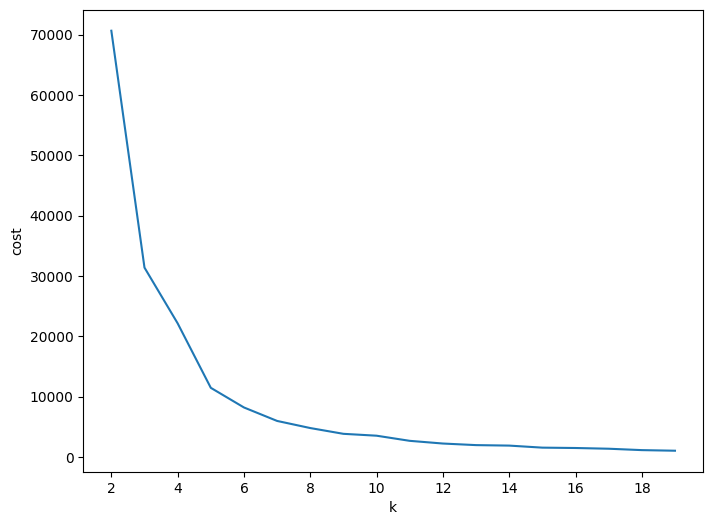

In [65]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Silhouette Analysis

In [66]:
#@title
#PySpark libraries
import time
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce  # For Python 3.x

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

def optimal_k(df_in,index_col,k_min, k_max,num_runs):
    '''
    Determine optimal number of clusters by using Silhoutte Score Analysis.
    :param df_in: the input dataframe
    :param index_col: the name of the index column
    :param k_min: the minmum number of the clusters
    :param k_max: the maxmum number of the clusters
    :param num_runs: the number of runs for each fixed clusters

    :return k: optimal number of the clusters
    :return silh_lst: Silhouette score
    :return r_table: the running results table

    :author: Wenqiang Feng
    :email:  von198@gmail.com
    '''

    start = time.time()
    silh_lst = []
    k_lst = np.arange(k_min, k_max+1)

    r_table = df_in.select(index_col).toPandas()
    r_table = r_table.set_index(index_col)
    centers = pd.DataFrame()

    for k in k_lst:
        silh_val = []
        for run in np.arange(1, num_runs+1):

            # Trains a k-means model.
            kmeans = KMeans()\
                    .setK(k)\
                    .setSeed(int(np.random.randint(100, size=1)))
            model = kmeans.fit(df_in)

            # Make predictions
            predictions = model.transform(df_in)
            r_table['cluster_{k}_{run}'.format(k=k, run=run)]= predictions.select('prediction').toPandas()

            # Evaluate clustering by computing Silhouette score
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)

        silh_array=np.asanyarray(silh_val)
        silh_lst.append(silh_array.mean())

    elapsed =  time.time() - start

    silhouette = pd.DataFrame(list(zip(k_lst,silh_lst)),columns = ['k', 'silhouette'])

    print('+------------------------------------------------------------+')
    print("|         The finding optimal k phase took %8.0f s.       |" %(elapsed))
    print('+------------------------------------------------------------+')


    return k_lst[np.argmax(silh_lst, axis=0)], silhouette , r_table

    k, silh_lst, r_table = optimal_k(scaledData,index_col,k_min, k_max,num_runs)
    spark.createDataFrame(silh_lst).show()

### Pipeline Architecture

In [67]:
from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans() \
          .setK(3) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(transformed)

cluster = model.transform(transformed)

### K-Means Cluster

In [71]:
cluster = model.transform(transformed)
cluster.show()

+--------------------+--------------------+-------+
|            features|     indexedFeatures|cluster|
+--------------------+--------------------+-------+
|[1.0,5.1,3.5,1.4,...|[1.0,5.1,3.5,1.4,...|      0|
|[2.0,4.9,3.0,1.4,...|[2.0,4.9,3.0,1.4,...|      0|
|[3.0,4.7,3.2,1.3,...|[3.0,4.7,3.2,1.3,...|      0|
|[4.0,4.6,3.1,1.5,...|[4.0,4.6,3.1,1.5,...|      0|
|[5.0,5.0,3.6,1.4,...|[5.0,5.0,3.6,1.4,...|      0|
|[6.0,5.4,3.9,1.7,...|[6.0,5.4,3.9,1.7,...|      0|
|[7.0,4.6,3.4,1.4,...|[7.0,4.6,3.4,1.4,...|      0|
|[8.0,5.0,3.4,1.5,...|[8.0,5.0,3.4,1.5,...|      0|
|[9.0,4.4,2.9,1.4,...|[9.0,4.4,2.9,1.4,...|      0|
|[10.0,4.9,3.1,1.5...|[10.0,4.9,3.1,1.5...|      0|
|[11.0,5.4,3.7,1.5...|[11.0,5.4,3.7,1.5...|      0|
|[12.0,4.8,3.4,1.6...|[12.0,4.8,3.4,1.6...|      0|
|[13.0,4.8,3.0,1.4...|[13.0,4.8,3.0,1.4...|      0|
|[14.0,4.3,3.0,1.1...|[14.0,4.3,3.0,1.1...|      0|
|[15.0,5.8,4.0,1.2...|[15.0,5.8,4.0,1.2...|      0|
|[16.0,5.7,4.4,1.5...|[16.0,5.7,4.4,1.5...|      0|
|[17.0,5.4,3

## Source 2 - End to End PySpark Clustering by Josephgeorgelewis

### Setting up a PySpark environment in Colab

In [73]:
#set up Java Dev Kit and download Spark and Hadoop 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz

# unpack Spark and Hadoop
!tar xf spark-3.2.4-bin-hadoop3.2.tgz

# set up home paths for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

--2023-06-01 18:30:05--  https://downloads.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.95.219, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301183180 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.4-bin-hadoop3.2.tgz’

spark-3.2.4-bin-had 100%[===================>] 287.23M  18.2MB/s    in 17s     

2023-06-01 18:30:23 (17.0 MB/s) - ‘spark-3.2.4-bin-hadoop3.2.tgz’ saved [301183180/301183180]



In [ ]:
# install, import and initialise findspark 
!pip install -q findspark
import findspark
findspark.init()

# set up spark session 
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

### Collecting data from an API

In [74]:
import requests
import json

In [75]:
# base URL 
url = 'https://api.le-systeme-solaire.net/rest/bodies'

# extra parameters, see full docs for more 
params = {'exclude' :'mass,vol,moons,discoveredBy,discoveryDate,alternativeName,axialTilt,avgTemp,mainAnomaly,argPeriapsis,longAscNode,rel,aroundPlanet,sideralOrbit,sideralRotation,dimension,flattening,polarRadius'}

#´make request and store as JSON, then get the bodies element (the data we need)
all_data = requests.get(url, params).json()
all_data.get('bodies')

# save file with data from the current request so we do not have to make multiple API calls to reset the data

with open('data.json', 'w') as f:
    json.dump(all_data.get('bodies'), f)
     

In [76]:
from pyspark.sql.types import StructType, StructField, BooleanType, FloatType, StringType

# set up schema for data to be stored with correct data types and nullable fields 
schema = StructType([
  StructField("id", StringType(), False), 
  StructField("englishName", StringType(), True),
  StructField("isPlanet", BooleanType(), True),
  StructField("density", FloatType(), True),
  StructField("gravity", FloatType(), True),
  StructField("escape", FloatType(), True)
])

# read in JSON file with the schema set 
df = spark.read.json('data.json', schema)
df.show(5)

+------+-----------+--------+-------+-------+------+
|    id|englishName|isPlanet|density|gravity|escape|
+------+-----------+--------+-------+-------+------+
|  lune|       Moon|   false|  3.344|   1.62|2380.0|
|phobos|     Phobos|   false|    1.9| 0.0057| 11.39|
|deimos|     Deimos|   false|   1.75|  0.003| 5.556|
|    io|         Io|   false|   3.53|   1.79|   0.0|
|europe|     Europa|   false|   3.01|   1.31|   0.0|
+------+-----------+--------+-------+-------+------+
only showing top 5 rows



### Data Cleaning

In [78]:
from pyspark.sql.functions import when, count, isnull

# alias all columns 
cols = df.columns
df.show()

# show count of when the column is null for each of those columns
df.select([count(when(isnull(c), c)).alias(c) for c in cols]).show()

+----------+-----------+--------+-------+-------+------+
|        id|englishName|isPlanet|density|gravity|escape|
+----------+-----------+--------+-------+-------+------+
|      lune|       Moon|   false|  3.344|   1.62|2380.0|
|    phobos|     Phobos|   false|    1.9| 0.0057| 11.39|
|    deimos|     Deimos|   false|   1.75|  0.003| 5.556|
|        io|         Io|   false|   3.53|   1.79|   0.0|
|    europe|     Europa|   false|   3.01|   1.31|   0.0|
|  ganymede|   Ganymede|   false|   1.94|  1.428|   0.0|
|  callisto|   Callisto|   false|   1.83|  1.235|   0.0|
|  amalthee|   Amalthea|   false|    3.1|   0.02|   0.0|
|   himalia|    Himalia|   false|    1.0|  0.062|   0.0|
|     elara|      Elara|   false|    1.0|  0.031|   0.0|
|  pasiphae|   Pasiphae|   false|    1.0|  0.022|   0.0|
|    sinope|     Sinope|   false|    1.0|  0.014|   0.0|
|  lysithea|   Lysithea|   false|    1.0|  0.013|   0.0|
|     carme|      Carme|   false|    1.0|  0.017|   0.0|
|    ananke|     Ananke|   fals

In [79]:
from pyspark.sql.functions import isnan

# check schema to find all numeric cols
df.printSchema()  

# list all numeric cols 
num_cols = ['density', 'gravity', 'escape']

# select a count of all the numeric columns where they are NaN and show
df.select([count(when(isnan(c), c)).alias(c) for c in num_cols]).show()

root
 |-- id: string (nullable = true)
 |-- englishName: string (nullable = true)
 |-- isPlanet: boolean (nullable = true)
 |-- density: float (nullable = true)
 |-- gravity: float (nullable = true)
 |-- escape: float (nullable = true)

+-------+-------+------+
|density|gravity|escape|
+-------+-------+------+
|      0|      0|     0|
+-------+-------+------+



In [80]:
import pandas as pd
import plotly.express as px

# convert the data frame to pandas for visualisation
outliers = df.toPandas()

# plot a scatter plot of all the points to find obvious outliers
scatter = px.scatter(outliers, 'gravity', 'escape', hover_name='englishName', template='ggplot2')
scatter.show()

# filter out Jupiter from PySpark DF as it was a clear outlier
df=df.filter(df.id!='jupiter')

# repeat above process to ensure the removal has worked properly
outliers = df.toPandas()

scatter = px.scatter(outliers, 'gravity', 'escape', hover_name='englishName', template='ggplot2')
scatter.show()

### Model Building

In [81]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# set up each processing step with the correct input columns and output
assemble=VectorAssembler(inputCols=num_cols, outputCol='features')
scale=StandardScaler(inputCol='features',outputCol='standardized')
km = KMeans(featuresCol = 'standardized')

# assemble the pipeline 
pipe = Pipeline(stages=[assemble, scale, km])

In [86]:
from pyspark.ml.evaluation import ClusteringEvaluator

# set up evaluator 
evaluator = ClusteringEvaluator()

# test between k=2 and 10 
for k in range(2,10):
  # set the KMeans stage of the pipe to hold each value of K and the random seed = 1 and fit that pipe to data  
  kmeans = pipe.getStages()[-1].setK(k).setSeed(1)  
  model = pipe.fit(df)
  
  # build a preds dataset of each k value
  preds = model.transform(df)

  # silhouette score each prediction set and print formatted output 
  silhouette = evaluator.evaluate(preds)
  print(f'Tested: {k} clusters: {silhouette}')


Tested: 2 clusters: 0.985906445228239
Tested: 3 clusters: 0.9853183536337629
Tested: 4 clusters: 0.9288686572576516
Tested: 5 clusters: 0.9063524257467865
Tested: 6 clusters: 0.8596777095050427
Tested: 7 clusters: 0.8360492437185751
Tested: 8 clusters: -0.7386038523165039
Tested: 9 clusters: 0.8514223592590151


The optimal k value for dense and well-defined clusters here is 2. However, there must be a tradeoff as by clustering into only two clusters the insight drawn from the model is significantly limited. There is a slight reduction in silhouette score as k is increased to 3 however three clusters should give more insight into the underlying data structures. For this reason the value of k=3 is chosen.

### Evaluation

In [83]:
# set the random seed for the algorithm and the value for k
pipe.getStages()[-1].setK(3).setSeed(1)  

# fit model and transform the data showing a cut of the data to check output
model = pipe.fit(df)
clusters = model.transform(df)
clusters.show(5)

vis_df = clusters.toPandas()

# build figure with 3D numeric dimensions and categorical isPlanet and prediction dimensions
fig = px.scatter_3d(vis_df, x='gravity', y='escape', z='density', color='prediction', symbol='isPlanet', template='ggplot2', hover_name='englishName')
fig.show()

+------+-----------+--------+-------+-------+------+--------------------+--------------------+----------+
|    id|englishName|isPlanet|density|gravity|escape|            features|        standardized|prediction|
+------+-----------+--------+-------+-------+------+--------------------+--------------------+----------+
|  lune|       Moon|   false|  3.344|   1.62|2380.0|[3.34400010108947...|[5.04482713061263...|         0|
|phobos|     Phobos|   false|    1.9| 0.0057| 11.39|[1.89999997615814...|[2.86637892886519...|         0|
|deimos|     Deimos|   false|   1.75|  0.003| 5.556|[1.75,0.003000000...|[2.64008588866244...|         0|
|    io|         Io|   false|   3.53|   1.79|   0.0|[3.52999997138977...|[5.32543034939712...|         0|
|europe|     Europa|   false|   3.01|   1.31|   0.0|[3.00999999046325...|[4.54094771411208...|         0|
+------+-----------+--------+-------+-------+------+--------------------+--------------------+----------+
only showing top 5 rows



The chart shows how well-defined the clusters are, with the bodies being split into large planetary bodies (Saturn and Neptune for example), smaller planetary bodies (including Earth and Mars) and the non-planets (like the Moon and Mars satellite Phobos). This model could now be used in practice to generate an unsupervised classification as to what kind of body something is once we know those measurable features like density, escape velocity and gravity. If other data has been used to cluster a different set of clusters could be produced perhaps to further classify those other bodies.